# Лабораторная 3
## Решающее дерево

Первые пункты повторяют либо полностью, либо почти прошлые лабораторные

В этом блоке я подключаю все нужные библиотеки которые использую в лабораторной работе

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer


## SPAM SMS

Загружаю датасет со спамсообщениям

In [ ]:
spam_path = "/content/spam.csv"
spam_df = pd.read_csv(spam_path, encoding="latin1")[["v1", "v2"]]
spam_df.columns = ["label", "message"]

print("Размер датасета:", spam_df.shape)
display(spam_df.head())

print("\nРаспределение классов:")
print(spam_df["label"].value_counts())


Размер датасета: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Распределение классов:
label
ham     4825
spam     747
Name: count, dtype: int64


В этом блоке я разделяю сообщения на признаки и метки, а затем делю данные на обучающую и тестовую выборки

In [ ]:
X = spam_df["message"]
y = spam_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", len(X_train))
print("Test:", len(X_test))


Train: 4457
Test: 1115


Сначала в пайплайн добавляю tf-idf, который переводит текст в числовой вид, а затем решающее дерево, которое и выполняет само предсказание, после я получаю прогнозы на тестовой выборке и считаю метрики и строю матрицу ошибок

=== Базовое дерево решений (спам) ===
Accuracy : 0.9596
Precision: 0.8714
Recall   : 0.8188
F1 (spam): 0.8443

               precision    recall  f1-score   support

         ham       0.97      0.98      0.98       966
        spam       0.87      0.82      0.84       149

    accuracy                           0.96      1115
   macro avg       0.92      0.90      0.91      1115
weighted avg       0.96      0.96      0.96      1115



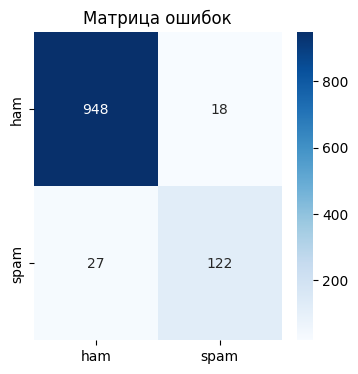

In [ ]:
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("tree", DecisionTreeClassifier(random_state=42))
])

baseline_clf.fit(X_train, y_train)
y_pred_base = baseline_clf.predict(X_test)

acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, pos_label="spam")
rec_base = recall_score(y_test, y_pred_base, pos_label="spam")
f1_base = f1_score(y_test, y_pred_base, pos_label="spam")

print("=== Базовое дерево решений (спам) ===")
print(f"Accuracy : {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall   : {rec_base:.4f}")
print(f"F1 (spam): {f1_base:.4f}")

print("\n", classification_report(y_test, y_pred_base))

cm = confusion_matrix(y_test, y_pred_base, labels=["ham","spam"])
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.title("Матрица ошибок")
plt.show()


### Гипотезы как можно улучшить модели:

- ограничить глубину дерева max_depth, чтобы избежать переобучения

- увеличить min_samples_split, чтобы дерево не делало слишком мелкие разбиения

- попробовать разные критерии разбиения gini и entropy

- подобрать гиперпараметры с помощью кросс-валидации


Здесь я настраиваю модель с помощью GridSearchcv

В пайплайне остаются те же шаги что и раньше: tf-idf и решающее дерево.
Я задаю сетку параметров для дерева и векторизатора, а gridsearch перебирает варианты и ищет комбинацию, которая дает лучший F1

In [ ]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("tree", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tree__criterion": ["gini", "entropy"],
    "tree__max_depth": [5, 10, 20, None],
    "tree__min_samples_split": [2, 5, 10],
}

grid = GridSearchCV(
    pipe, param_grid,
    scoring="f1_macro", cv=3, n_jobs=-1, verbose=1
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший F1:", grid.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Лучшие параметры: {'tfidf__ngram_range': (1, 1), 'tree__criterion': 'gini', 'tree__max_depth': None, 'tree__min_samples_split': 5}
Лучший F1: 0.9127757296728679


Проверяю как работает модель на тестовых данных и сстрою матрицу ошибок, а так же сравниваю результаты моделей

=== Улучшенное дерево решений ===
Accuracy : 0.9587
Precision: 0.8601
Recall   : 0.8255
F1 (spam): 0.8425

               precision    recall  f1-score   support

         ham       0.97      0.98      0.98       966
        spam       0.86      0.83      0.84       149

    accuracy                           0.96      1115
   macro avg       0.92      0.90      0.91      1115
weighted avg       0.96      0.96      0.96      1115



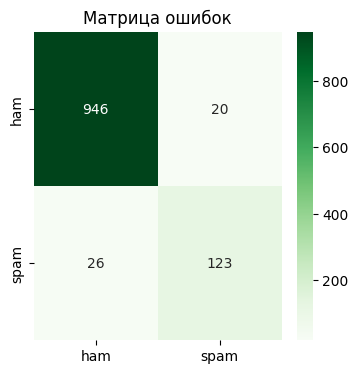

,model,accuracy,precision_spam,recall_spam,f1_spam
0,baseline,0.959641,0.871429,0.818792,0.844291
1,improved,0.958744,0.860140,0.825503,0.842466


In [ ]:
best_clf = grid.best_estimator_
y_pred_best = best_clf.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, pos_label="spam")
rec_best = recall_score(y_test, y_pred_best, pos_label="spam")
f1_best = f1_score(y_test, y_pred_best, pos_label="spam")

print("=== Улучшенное дерево решений ===")
print(f"Accuracy : {acc_best:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall   : {rec_best:.4f}")
print(f"F1 (spam): {f1_best:.4f}")

print("\n", classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best, labels=["ham","spam"])
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.title("Матрица ошибок")
plt.show()

pd.DataFrame({
    "model": ["baseline", "improved"],
    "accuracy": [acc_base, acc_best],
    "precision_spam": [prec_base, prec_best],
    "recall_spam": [rec_base, rec_best],
    "f1_spam": [f1_base, f1_best],
})


## Рейтинг фильмов

загружаю таблицу с рейтингами и таблицу с информацией о фильмах. Чтобы ускорить работу беру только 50 тысяч оценок. Потом объединяю две таблицы по movieId чтобы у каждой оценки появились данные о самом фильме

In [ ]:
ratings_path = "/content/rating.csv"
movies_path = "/content/movie.csv"

ratings_df = pd.read_csv(ratings_path, nrows=50000)
movies_df = pd.read_csv(movies_path)

print(ratings_df.shape, movies_df.shape)

data_ml = ratings_df.merge(movies_df, on="movieId", how="left")
display(data_ml.head())


(50000, 4) (27278, 3)


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Сначала с помощью регулярного выражения я вытаскиваю год из названия фильма. Если года нет то строка удаляется. Затем я превращаю строку с жанрами в список жанров и кодирую их в набор бинарных признаков через multilabelbinizer

In [ ]:
import re

def extract_year(title):
    m = re.search(r"(19\d{2}|20\d{2})", str(title))
    return int(m.group(0)) if m else np.nan

data_ml["year"] = data_ml["title"].apply(extract_year)
data_ml = data_ml.dropna(subset=["year"])

data_ml["genres_list"] = data_ml["genres"].apply(lambda x: x.split("|"))

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(data_ml["genres_list"])
genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb.classes_])

features_ml = pd.concat(
    [data_ml[["rating", "year"]].reset_index(drop=True),
     genres_df.reset_index(drop=True)], axis=1
)

display(features_ml.head())


,rating,year,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,3.5,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.5,1995,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,3.5,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


Здесь я разделяю таблицу признаков на входные данные и целевую переменную которой является рейтинг фильма. Потом с помощью train_test_split делю данные на обучающую и тестовую части

In [ ]:
X_reg = features_ml.drop(columns=["rating"])
y_reg = features_ml["rating"]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


Здесь я обучаю базовую модель решающего дерева для регрессии.
Модель пытается предсказывать рейтинг фильма по году и жанрам.
После обучения я получаю предсказания на тестовой выборке и считаю основные метрики и строю график.

0.7951420815038269 1.0201797177895056 0.07174173533892225


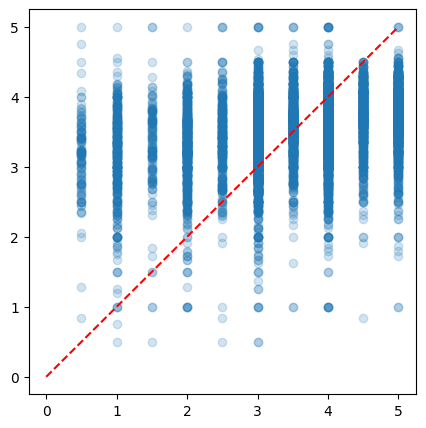

In [ ]:
tree_reg_base = DecisionTreeRegressor(random_state=42)
tree_reg_base.fit(X_reg_train, y_reg_train)

y_pred_base = tree_reg_base.predict(X_reg_test)

mae_base = mean_absolute_error(y_reg_test, y_pred_base)
rmse_base = mean_squared_error(y_reg_test, y_pred_base)**0.5
r2_base = r2_score(y_reg_test, y_pred_base)

print(mae_base, rmse_base, r2_base)

plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_pred_base, alpha=0.2)
plt.plot([0,5],[0,5],'r--')
plt.show()


Создаю пайплайн для улучшенной модели то бишь сначала масштбирую признаки, а потом использую решающее дерево.
Через gridsearchcv подбираю лучшие параметры дерева, такие как максимальная глубина и минимальное число объектов для разбиения.
gridsearch перебирает все варианты на кросс валидации и ищет модель с минимальной ошибкой MAE

In [ ]:
pipe_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeRegressor(random_state=42))
])

grid_reg = GridSearchCV(
    pipe_reg,
    {"tree__max_depth": [5,10,20,None],
     "tree__min_samples_split": [2,5,10]},
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid_reg.fit(X_reg_train, y_reg_train)

print(grid_reg.best_params_)
print(-grid_reg.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'tree__max_depth': 20, 'tree__min_samples_split': 10}
0.8079042016903011


Использую лучшую модель, которую нашёл GridSearchCV, и проверяю её на тестовой выборке.
Считаю те же метрики что и для базового дерева, чтобы сравнить качество

0.792877360404097 1.0166330717931142 0.07818468013030633


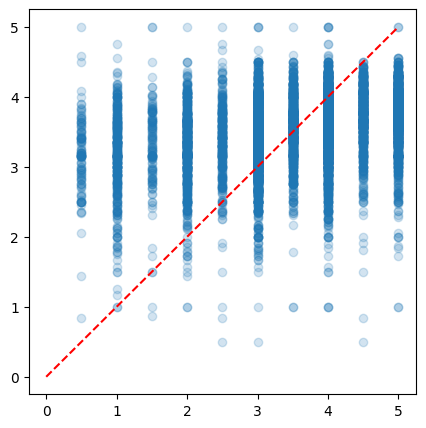

,model,MAE,RMSE,R2
0,baseline,0.795142,1.020180,0.071742
1,improved,0.792877,1.016633,0.078185


In [ ]:
best_reg = grid_reg.best_estimator_
y_best = best_reg.predict(X_reg_test)

mae_best = mean_absolute_error(y_reg_test, y_best)
rmse_best = mean_squared_error(y_reg_test, y_best)**0.5
r2_best = r2_score(y_reg_test, y_best)

print(mae_best, rmse_best, r2_best)

plt.figure(figsize=(5,5))
plt.scatter(y_reg_test, y_best, alpha=0.2)
plt.plot([0,5],[0,5],'r--')
plt.show()

pd.DataFrame({
    "model": ["baseline", "improved"],
    "MAE": [mae_base, mae_best],
    "RMSE": [rmse_base, rmse_best],
    "R2": [r2_base, r2_best],
})


## Имплементация

В этом блоке я написал свою собственную реализацию решающего дерева

Модель сама ищет лучший признак и порог разделяя данные на две части. Если дерево слишком глубокое или объектов мало, я возвращаю прогноз узла. Предсказание для одного объекта проходит по дереву сверху вниз

In [ ]:
import numpy as np
from collections import Counter

class MyDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, task="classification"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.tree = None

    # критерии
    def gini(self, y):
        counts = np.bincount(y)
        probs = counts / len(y)
        return 1 - np.sum(probs**2)

    def mse(self, y):
        return np.mean((y - np.mean(y))**2)

    # поиск лучшего разбиения
    def best_split(self, X, y):
        best_feat, best_thr = None, None
        best_score = float("inf")

        n, d = X.shape

        for feat in range(d):
            values = np.unique(X[:, feat])
            for thr in values:
                left = y[X[:, feat] <= thr]
                right = y[X[:, feat] > thr]

                if len(left) < 1 or len(right) < 1:
                    continue

                if self.task == "classification":
                    score = (len(left)*self.gini(left) + len(right)*self.gini(right)) / n
                else:
                    score = (len(left)*self.mse(left) + len(right)*self.mse(right)) / n

                if score < best_score:
                    best_score = score
                    best_feat = feat
                    best_thr = thr

        return best_feat, best_thr

    # рекурсивное построение дерева
    def build_tree(self, X, y, depth=0):
        if (self.max_depth is not None and depth >= self.max_depth) or len(y) < self.min_samples_split:
            if self.task == "classification":
                return Counter(y).most_common(1)[0][0]
            else:
                return np.mean(y)

        feat, thr = self.best_split(X, y)
        if feat is None:
            return Counter(y).most_common(1)[0][0] if self.task == "classification" else np.mean(y)

        left_idx = X[:, feat] <= thr
        right_idx = ~left_idx

        return {
            "feat": feat,
            "thr": thr,
            "left": self.build_tree(X[left_idx], y[left_idx], depth+1),
            "right": self.build_tree(X[right_idx], y[right_idx], depth+1)
        }

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self.build_tree(X, y)
        return self

    def predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feat"]] <= node["thr"]:
            return self.predict_one(x, node["left"])
        else:
            return self.predict_one(x, node["right"])

    def predict(self, X):
        X = np.array(X)
        return np.array([self.predict_one(x, self.tree) for x in X])


В этом блоке я готовлю данные для своей собственной модели дерева решений. Tf-idf как и раньше используется чтобы превратить текст сообщений в числовые признаки. А маленький TF-IDF с ограничением до 3000 признаков нужен чтобы не перегружать память в гугл колабе. Потом я преобразую обучающие и тестовые сообщения в массивы обычных чисел потому что моя реализация дерева не умеет работать с разреженными матрицами.

In [ ]:

# маленький TF-IDF чтобы не перегружать память
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_small = TfidfVectorizer(
    stop_words="english",
    max_features=3000,   # до 3к
    min_df=3,
    ngram_range=(1,2)
)

X_train_vec = tfidf_small.fit_transform(X_train).toarray()
X_test_vec = tfidf_small.transform(X_test).toarray()

y_train_cls = (y_train == "spam").astype(int).values
y_test_cls  = (y_test == "spam").astype(int).values

my_tree_clf = MyDecisionTree(task="classification")
my_tree_clf.fit(X_train_vec, y_train_cls)

y_pred_my = my_tree_clf.predict(X_test_vec)


Cчитаю метрики для своей реализации дерева решений.

Вывожу таблицу в которой сравниваю качество моей модели с улучшенной моделью из sklearn.

In [ ]:
acc_my = accuracy_score(y_test_cls, y_pred_my)
prec_my = precision_score(y_test_cls, y_pred_my)
rec_my = recall_score(y_test_cls, y_pred_my)
f1_my = f1_score(y_test_cls, y_pred_my)

print("=== Моя модель дерева (классификация) ===")
print(f"Accuracy: {acc_my:.4f}")
print(f"Precision: {prec_my:.4f}")
print(f"Recall: {rec_my:.4f}")
print(f"F1: {f1_my:.4f}")

pd.DataFrame({
    "model": ["sklearn_improved", "my_tree"],
    "accuracy": [acc_best, acc_my],
    "precision": [prec_best, prec_my],
    "recall": [rec_best, rec_my],
    "f1": [f1_best, f1_my]
})


=== Моя модель дерева (классификация) ===
Accuracy: 0.9587
Precision: 0.8552
Recall: 0.8322
F1: 0.8435


,model,accuracy,precision,recall,f1
0,sklearn_improved,0.958744,0.860140,0.825503,0.842466
1,my_tree,0.958744,0.855172,0.832215,0.843537


В этом блоке я использую лучшие параметры которые подобрал GridSearch для sklearn модели. Я беру глубину дерева и минимальное число объектов для разбиения и передаю их в дерево решений чтобы сделать улучшенную версию уже моей модели

После этого я снова обучаю своё дерево но уже с лучшими настройками и получаю предсказания на тестовой выборке

In [ ]:
best_params = grid.best_params_
print(best_params)

my_tree_clf_imp = MyDecisionTree(
    max_depth=best_params["tree__max_depth"],
    min_samples_split=best_params["tree__min_samples_split"],
    task="classification"
)

my_tree_clf_imp.fit(X_train_vec, y_train_cls)
y_pred_my_imp = my_tree_clf_imp.predict(X_test_vec)


{'tfidf__ngram_range': (1, 1), 'tree__criterion': 'gini', 'tree__max_depth': None, 'tree__min_samples_split': 5}


Оцениваю качество улучшенной версии моей модели дерева решений, вычисляю те же метрики что и раньше: accuracy, precision, recall и F1

Вывожу таблицу где сравниваю результаты улучшенной версии моего дерева и улучшенной модели sklearn

In [ ]:
acc_my_imp = accuracy_score(y_test_cls, y_pred_my_imp)
prec_my_imp = precision_score(y_test_cls, y_pred_my_imp)
rec_my_imp = recall_score(y_test_cls, y_pred_my_imp)
f1_my_imp = f1_score(y_test_cls, y_pred_my_imp)

pd.DataFrame({
    "model": ["sklearn_improved", "my_tree_improved"],
    "accuracy": [acc_best, acc_my_imp],
    "precision": [prec_best, prec_my_imp],
    "recall": [rec_best, rec_my_imp],
    "f1": [f1_best, f1_my_imp]
})


,model,accuracy,precision,recall,f1
0,sklearn_improved,0.958744,0.860140,0.825503,0.842466
1,my_tree_improved,0.957848,0.854167,0.825503,0.839590


Для рейтинга фильмов

Готовлю данные для своей реализации дерева решений но уже для задачи регрессии. Я использую тот же масштабировщик который был в лучшей sklearn модели чтобы данные для обеих моделей были одинаковыми

In [ ]:
scaler_best = best_reg.named_steps["scaler"]

X_reg_train_scaled = scaler_best.transform(X_reg_train)
X_reg_test_scaled = scaler_best.transform(X_reg_test)

my_tree_reg = MyDecisionTree(task="regression")
my_tree_reg.fit(X_reg_train_scaled, y_reg_train.values)

y_pred_my_reg = my_tree_reg.predict(X_reg_test_scaled)


Считаю метрики качества для своей модели дерева решений в задаче регрессии и вывожу таблицу

In [ ]:
mae_my = mean_absolute_error(y_reg_test, y_pred_my_reg)
rmse_my = mean_squared_error(y_reg_test, y_pred_my_reg)**0.5
r2_my = r2_score(y_reg_test, y_pred_my_reg)

pd.DataFrame({
    "model": ["sklearn_improved", "my_tree"],
    "MAE": [mae_best, mae_my],
    "RMSE": [rmse_best, rmse_my],
    "R2": [r2_best, r2_my]
})


,model,MAE,RMSE,R2
0,sklearn_improved,0.792877,1.016633,0.078185
1,my_tree,0.794913,1.019926,0.072203


Тут использую лучшие параметры которые были найдены для sklearn модели и передаю их в свою реализацию дерева уже для регрессии.

После обучения модели я делаю предсказания и считаю метрики MAE, RMSE и R². В конце вывожу таблицу где сравниваю качество моделей.

In [ ]:
best_params_reg = grid_reg.best_params_

my_tree_reg_imp = MyDecisionTree(
    max_depth=best_params_reg["tree__max_depth"],
    min_samples_split=best_params_reg["tree__min_samples_split"],
    task="regression"
)

my_tree_reg_imp.fit(X_reg_train_scaled, y_reg_train.values)
y_pred_my_reg_imp = my_tree_reg_imp.predict(X_reg_test_scaled)

mae_my_imp = mean_absolute_error(y_reg_test, y_pred_my_reg_imp)
rmse_my_imp = mean_squared_error(y_reg_test, y_pred_my_reg_imp)**0.5
r2_my_imp = r2_score(y_reg_test, y_pred_my_reg_imp)

pd.DataFrame({
    "model": ["sklearn_improved", "my_tree_improved"],
    "MAE": [mae_best, mae_my_imp],
    "RMSE": [rmse_best, rmse_my_imp],
    "R2": [r2_best, r2_my_imp]
})


,model,MAE,RMSE,R2
0,sklearn_improved,0.792877,1.016633,0.078185
1,my_tree_improved,0.792383,1.015467,0.080299


## Вывод

В этой лабораторной я разобрался как работают решающие деревья в задачах классификации и регрессии, построил базовые и улучшенные модели с подбором гиперпараметров, а затем реализовал своё собственное дерево решений и сравнил его работу со sklearn. Улучшенные модели показали более высокие или такие же метрики, а моя реализация хоть дала результаты хуже, но работала.